# filter temporally surface fields


In [1]:
import os

import numpy as np
import xarray as xr
import pandas as pd
import dask.dataframe as dd

from matplotlib import pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs

import mitequinox.utils as ut
import mitequinox.plot as pl
import mitequinox.sigp as sp
import mitequinox.parcels as pa

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5389729.datarmor0/parcels-55081/libparcels_random_51a6c606-c934-4a6c-9758-f3012ba4fe23.so


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=5) # postprocessing
    #w = cluster.scale(jobs=20) # full
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

Client Scheduler: tcp://10.148.1.57:41475 Dashboard: http://10.148.1.57:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---

## load data from a regional selection

In [4]:
# select a region, here California
region = "california"
out_dir = os.path.join("/home/datawork-lops-osi/aponte/mit4320", region)
parcels_index = "time" # index chosen for the parcel data

In [5]:
# deduce useful variables
llc_zarr = os.path.join(out_dir, "llc.zarr")
parcels_name = "llc_parcels_"+parcels_index
parcels_path = os.path.join(out_dir, parcels_name)

In [6]:
# load
ds = xr.open_zarr(llc_zarr)
df = dd.read_parquet(parcels_path)

# useful later on
llc_lon, llc_lat = ds.XC.persist(), ds.YC.persist()

Overview

In [6]:
_ds = ds.isel(time=0).persist()
_df = df.compute().iloc[::100,:]

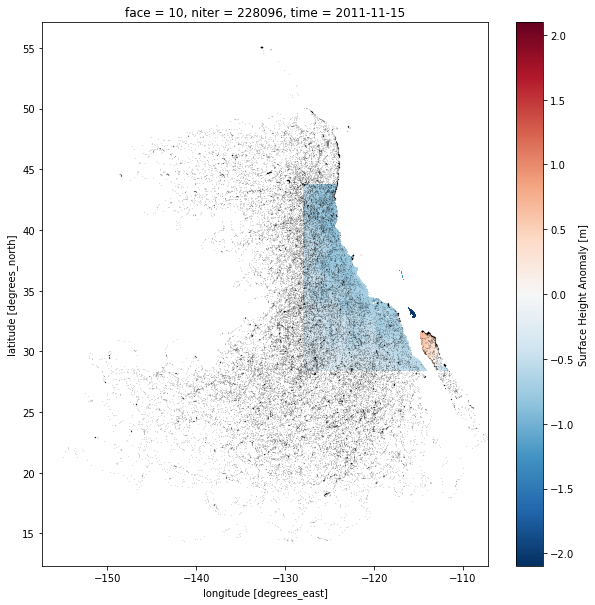

In [7]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(_df.lon,_df.lat,".", color="k", markersize=0.1)
_ds.Eta.plot(x="XC", y="YC", ax=ax)

---

## define the filter and utils

In [8]:
dt = 1/24 # in days

tidal_omega = sp.get_tidal_frequencies("M2", "K1")
omega, domega, band_name = tidal_omega["M2"], .2, "semidiurnal"

h = sp.generate_filter(omega, T=10, dt=dt, bandwidth=domega, normalized_bandwidth=None)
h_hat, w = sp.filter_response(h, dt=dt)

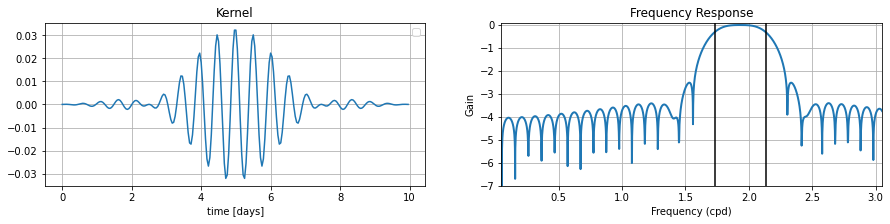

In [9]:
fig, axes = plt.subplots(1,2, figsize=(15,3))
ax = axes[0]
t = np.arange(0, h.size)*dt
ax.plot(t, h)
ax.grid()
ax.set_xlabel('time [days]')
ax.set_title('Kernel')
ax.legend()

ax = axes[1]
ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
ax.axvline(omega-domega, color='k')
ax.axvline(omega+domega, color='k')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
#ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 3.05)
ax.grid(True)

In [10]:
from scipy import signal

def convolve(x, h=None, hilbert=False):
    """ Convolve an input signal with a kernel
    Optionaly compute the Hilbert transform of the resulting time series
    """
    #x_f = im.convolve1d(x, h, axis=1, mode='constant')
    x_f = signal.filtfilt(h, [1], x, axis=-1)
    if hilbert:
        return signal.hilbert(x_f)
    else:
        return x_f

def filt(v, h, hilbert=False):
    output_dtype = complex if hilbert else float
    gufunc_kwargs = dict(output_sizes={'time': len(v.time)})
    return xr.apply_ufunc(convolve, v, kwargs={'h': h, 'hilbert': hilbert},
                    dask='parallelized', output_dtypes=[output_dtype],
                    input_core_dims=[['time']],
                    output_core_dims=[['time']],
                    dask_gufunc_kwargs = gufunc_kwargs,
                         )

---
## selected locations


In [11]:
points = dict(north=[-126, 36],
              south=[-126, 30],
             )

def find_ij(lon, lat):
    d = (llc_lon-lon)**2 + (llc_lat-lat)**2
    d = d.where(d==d.min().compute(), drop=True)[0]
    return int(d.i), int(d.j.values)

points_ij = {p: find_ij(v[0], v[1]) for p, v in points.items()}
points_ij

{'north': (3028, 95), 'south': (3401, 95)}

see [this notebook](https://nbviewer.jupyter.org/github/apatlpo/mit_equinox/blob/master/sandbox/plot_uv.ipynb) to pick points

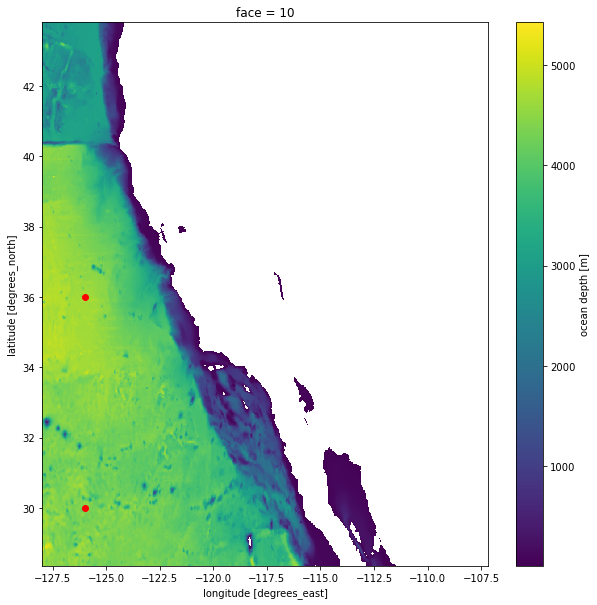

In [12]:
depth = ds.Depth
depth = depth.where(depth>0)

fig, ax = plt.subplots(1,1, figsize=(10,10))
depth.plot(x="XC", y="YC")

for p, l in points.items():
    ax.plot(l[0], l[1], "o", color="r")

In [43]:
_d = xr.DataArray(list(points),dims="point", name="point")
# the line below might be very inefficient
dsp = xr.concat([ds.sel(i=i[0], i_g=i[0], j=i[1], j_g=i[1])
                 for p, i in points_ij.items()],
                dim=_d,
               )
dsp = dsp.chunk({"time": -1}).persist()
#dsp

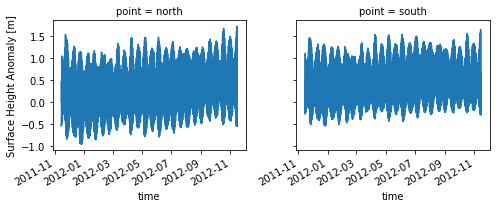

In [44]:
dsp["Eta"].plot.line(x="time", col='point')

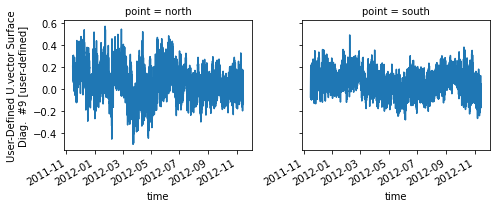

In [45]:
dsp["SSU"].plot.line(x="time", col='point')

Filter fields

In [46]:
for v in dsp:
    dsp[v+"_hat"] = filt(dsp[v], h, hilbert=True)

_t = ( (ds.time - pd.Timestamp("2000-01-01").to_numpy() )
      /pd.Timedelta("1s").to_numpy()
     )
dsp["exp"] = np.exp(-1j*2.*np.pi*tidal_omega["M2"]*_t/86400)

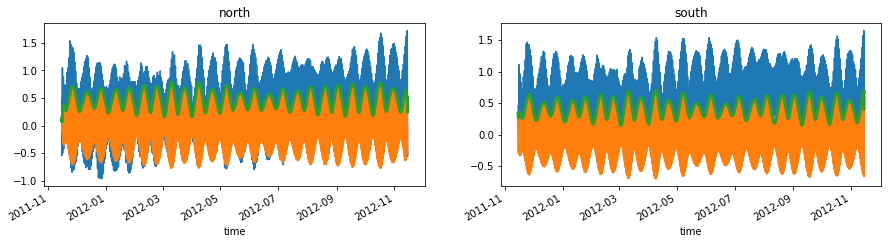

In [55]:
fig, axes =  plt.subplots(1,2, figsize=(15,3))

_ds = dsp
v = "Eta"

for p, ax in zip(dsp.point, axes):
    _ds[v].sel(point=p).plot.line(ax=ax, x="time")
    np.real(_ds[v+"_hat"]).sel(point=p).plot.line(ax=ax, x="time")
    np.abs(_ds[v+"_hat"]*_ds["exp"]).sel(point=p).plot.line(ax=ax, x="time", lw=3)
    ax.set_title(p.values)

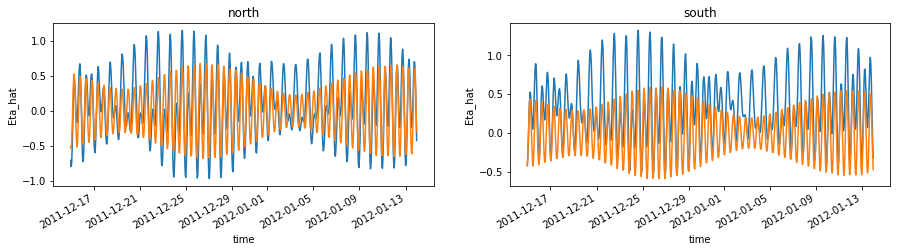

In [56]:
fig, axes =  plt.subplots(1,2, figsize=(15,3))

_ds = dsp.isel(time=slice(30*24,60*24))
v = "Eta"

for p, ax in zip(dsp.point, axes):
    _ds[v].sel(point=p).plot.line(ax=ax, x="time")
    np.real(_ds[v+"_hat"]).sel(point=p).plot.line(ax=ax, x="time")
    ax.set_title(p.values)

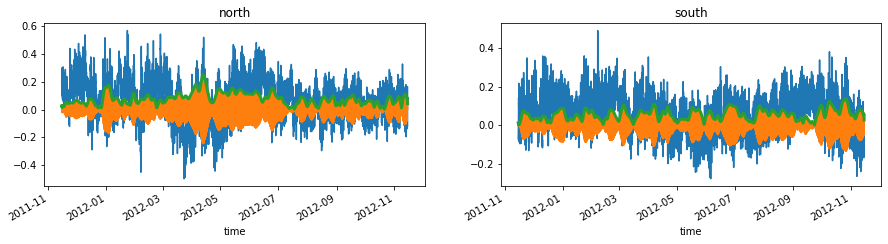

In [59]:
fig, axes =  plt.subplots(1,2, figsize=(15,3))

_ds = dsp
v = "SSU"

for p, ax in zip(dsp.point, axes):
    _ds[v].sel(point=p).plot.line(ax=ax, x="time")
    np.real(_ds[v+"_hat"]).sel(point=p).plot.line(ax=ax, x="time")
    np.abs(_ds[v+"_hat"]*_ds["exp"]).sel(point=p).plot.line(ax=ax, x="time", lw=3)
    ax.set_title(p.values)

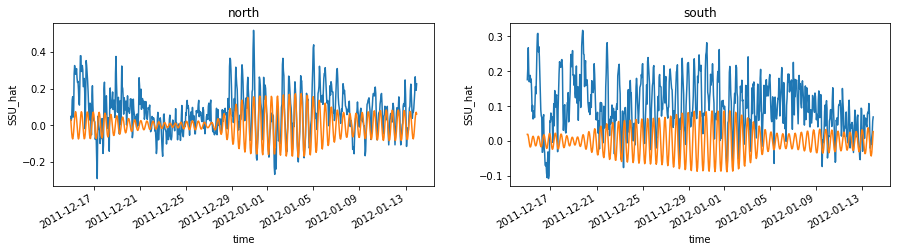

In [60]:
fig, axes =  plt.subplots(1,2, figsize=(15,3))

_ds = dsp.isel(time=slice(30*24,60*24))
v = "SSU"

for p, ax in zip(dsp.point, axes):
    _ds[v].sel(point=p).plot.line(ax=ax, x="time")
    np.real(_ds[v+"_hat"]).sel(point=p).plot.line(ax=ax, x="time")
    ax.set_title(p.values)

---
## filter a region and store

In [42]:
# should show the size of the dataset to know if we can load it in memory
print('dataset size: %.1f GB' %(ds.nbytes / 1e9))

# rechunk along time
ds = ds.chunk(dict(time=-1, j=64))

for v in ds:
    if "_hat" not in v:
        ds[v+"_hat"] = filt(ds[v], h, hilbert=True).astype(np.complex64)

# should rechunk here into less elongated chunks along time

dataset size: 105.5 GB


peaks at 500GB below

In [43]:
zarr = os.path.join(out_dir, "llc_"+band_name)
ds = ut._reset_chunk_encoding(ds)
ds.to_zarr(zarr, mode="w")

rechunk data into more manageable shape

In [44]:
ds = xr.open_zarr(zarr)

chunks_new = dict(time=512, i=256, j=256)
chunks_new["i_g"] = chunks_new["i"]
chunks_new["j_g"] = chunks_new["j"]

ds = ds.chunk(chunks_new)

zarr_rc = os.path.join(out_dir, "llc_"+band_name+"_rechunked")
ds = ut._reset_chunk_encoding(ds)
ds.to_zarr(zarr_rc, mode="w")

### inspect result

In [45]:
cluster.scale(jobs=2)

In [92]:
zarr = os.path.join(out_dir, "llc_"+band_name+"_rechunked")
ds = xr.open_zarr(zarr)
ds["SSU"] = ds["SSU"].rename({"i_g": "i"})
ds["SSU_hat"] = ds["SSU_hat"].rename({"i_g": "i"})    
ds["SSV"] = ds["SSV"].rename({"j_g": "j"})
ds["SSV_hat"] = ds["SSV_hat"].rename({"j_g": "j"})    

In [93]:
_ds = (ds
       .isel(time=30*24)
       .chunk(dict(i=-1, j=-1))
       .persist()
      )

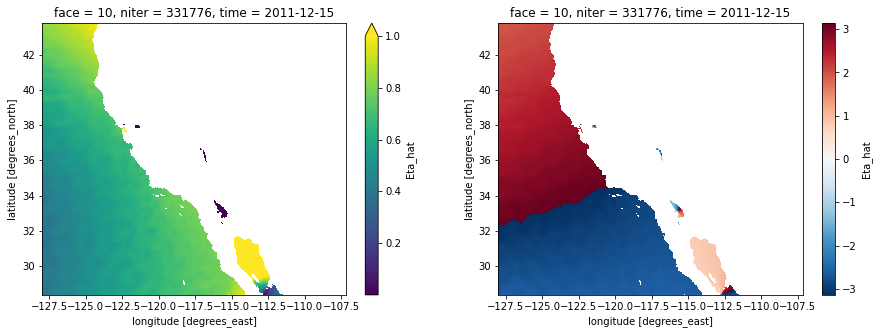

In [94]:
kw = dict(x="XC", y="YC")
fig, axes = plt.subplots(1,2, figsize=(15,5))
np.abs(_ds["Eta_hat"]).plot(ax=axes[0], vmax=1., **kw)
xr.ufuncs.angle(_ds["Eta_hat"]).plot(ax=axes[1], **kw)

In [95]:
def plot_ri(ds, v, i=None, j=None, xlim=None, ylim=None, **kwargs):
    _ds = ds
    if i is not None:
        da = da.sel(i=i)
    if j is not None:
        da = da.sel(j=j)
    da = _ds[v+"_hat"]
    fig, axes = plt.subplots(1,2, figsize=(15,5))
    kw = dict(x="XC", y="YC", **kwargs)
    np.real(da).plot(ax=axes[0], **kw)
    axes[0].set_title("real({}_M2) {}".format(v,_ds.time.dt.strftime("%Y-%M%d").values))
    if xlim is not None:
        axes[0].set_xlim(xlim)
    if ylim is not None:
        axes[0].set_ylim(ylim)
    np.imag(da).plot(ax=axes[1], **kw)
    #
    axes[1].set_title("imag({}_M2) {}".format(v,_ds.time.dt.strftime("%Y-%M%d").values))
    if xlim is not None:
        axes[1].set_xlim(xlim)
    if ylim is not None:
        axes[1].set_ylim(ylim)    

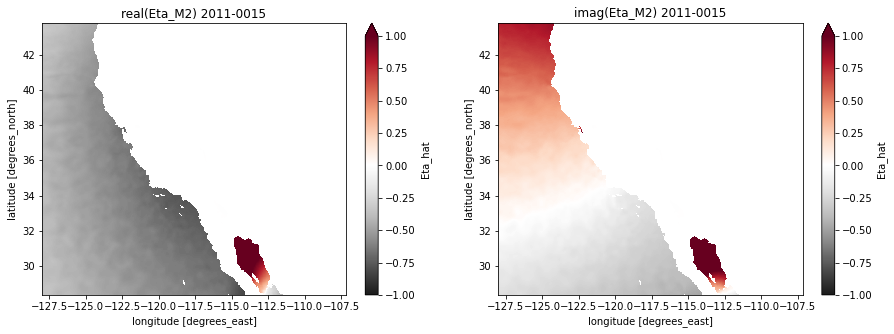

In [96]:
plot_ri(_ds, "Eta", vmax=1., cmap="RdGy_r")

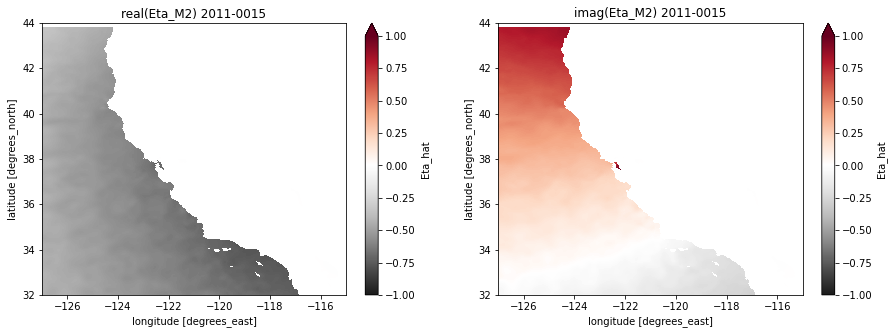

In [87]:
xlim, ylim = (-127, -115), (32, 44)
plot_ri(_ds, "Eta", vmax=1., cmap="RdGy_r", xlim=xlim, ylim=ylim)

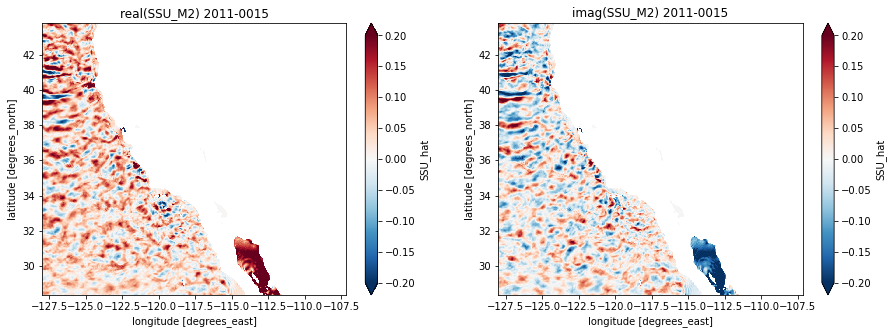

In [98]:
plot_ri(_ds, "SSU", vmax=.2)

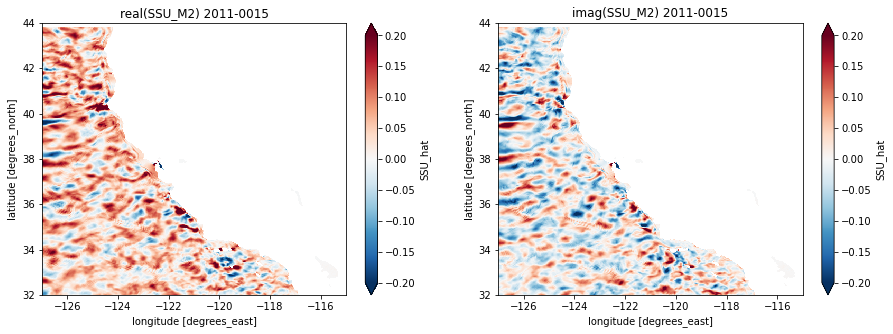

In [99]:
#plot_ri(_ds, "SSU", vmax=.2, i=slice(1000,2000), j=slice(2000,3000))
xlim, ylim = (-127, -115), (32, 44)
plot_ri(_ds, "SSU", vmax=.2, xlim=xlim, ylim=ylim)


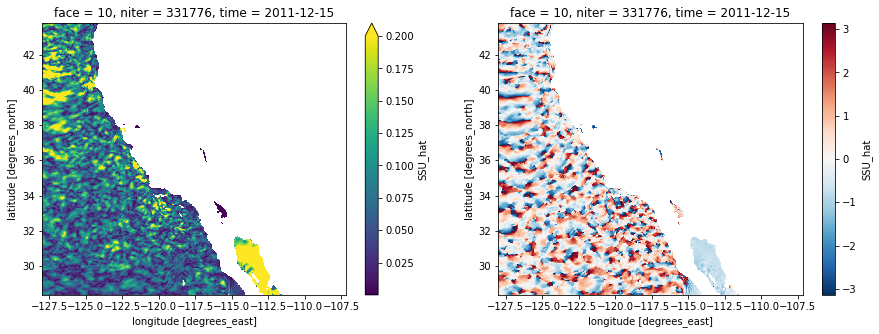

In [97]:
kw = dict(x="XC", y="YC")
fig, axes = plt.subplots(1,2, figsize=(15,5))
np.abs(_ds["SSU_hat"]).plot(ax=axes[0], vmax=.2, **kw)
xr.ufuncs.angle(_ds["SSU_hat"]).plot(ax=axes[1], **kw)

### movies

In [9]:
import cartopy.crs as ccrs
from dask.delayed import delayed

In [11]:
parquet_path = parcels_path
llc_path = os.path.join(ut.scratch, "tmp-movie.zarr")

def get_background(region, **kwargs):
    dkwargs = dict(dij=1, 
                   #v="SSU_hat_real", vmin=-.2, vmax=.2, 
                   v="Eta_hat_real", vmin=-1., vmax=1., 
                   colorbar=True, cmap="RdGy_r",
                   land=False,
                   swot_tracks=True, 
                   figsize=(10, 10),
                   zarr=llc_path,
                  )
    dkwargs.update(region=region, **kwargs)
    return dkwargs

def get_proj(extent):
    lon = (extent[0]+extent[1])*.5
    lat = (extent[2]+extent[3])*.5
    return ccrs.Orthographic(central_longitude=lon, 
                     central_latitude=lat, 
                     globe=None,
                    )

In [12]:
extent = [-128, -123, 33, 38]
t_range = pd.date_range("2012-1-1", "2012-2-1", freq="1H")

region = dict(extent = extent,
              projection = get_proj(extent),
              dticks = [1,1],
             )

background = get_background(region)

In [13]:
kwargs = dict(t_delta='1H',
              parquet_dir=parquet_path,              
              flag_drifters=0,
              drifter_kwargs={"color": "cadetblue", "lw": 3},
              trail='5D',
              background=background,
              overwrite=True,
             )

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


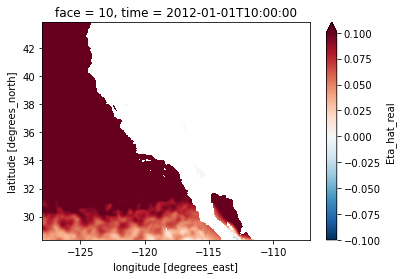

In [14]:
# write temporary dataset

if True:

    zarr = os.path.join(out_dir, "llc_"+band_name+"_rechunked")
    ds = (xr.open_zarr(zarr)
          .sel(time=t_range)
         )

    _t = ( (ds.time - pd.Timestamp("2000-01-01").to_numpy() )
          /pd.Timedelta("1s").to_numpy()
         )
    ds["exp"] = np.exp(-1j*2.*np.pi*tidal_omega["M2"]*_t/86400)
    
    da = np.real(ds["Eta_hat"]*ds["exp"]).rename("Eta_hat_real")
    #da = np.real(ds["SSU_hat"]*ds["exp"]).rename("SSU_hat_real")
    #da = da.rename({"i_g": "i"})

    da = da.assign_coords(XC=llc_lon, YC=llc_lat)
    da = da.chunk({"time": 1, "i": -1, "j": -1})

    del da["niter"]
    da.to_dataset().to_zarr(llc_path, mode="w")

    da.isel(time=10).plot(x="XC", y="YC", vmax=.1)

background printed


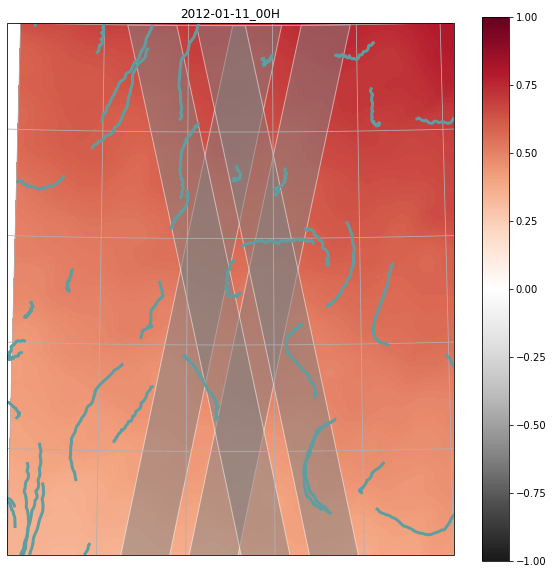

In [15]:
# to create isolated figures:
t_start = t_range[0] + pd.Timedelta('10D')
t_end = t_start #+ pd.Timedelta('1H')

pa.plot_llc_parcels(t_start, t_end, offline=False, **kwargs)

In [16]:
Nb = len(client.nthreads())
rg = range(0, t_range.size-1)
if len(rg)/Nb>1:
    II = np.array_split(rg,len(rg)/Nb)
else:
    II = [list(rg)]  
print('%d batches to be done'%len(II))

21 batches to be done


In [ ]:
#
delayed_fig = delayed(pa.plot_llc_parcels)
#
for I in II:
    print(' batch %d-%d'%(I[0],I[-1]))
    values = [delayed_fig(t_range[i], t_range[i+1], **kwargs) for i in I]
    futures = client.compute(values)
    results = client.gather(futures)

 batch 0-35
 batch 36-71


---

In [17]:
w = cluster.scale_up(30)

In [ ]:
client.restart()

In [16]:
cluster.close()